In [ ]:
# https://www.geeksforgeeks.org/long-short-term-memory-networks-using-pytorch/

Librairies


In [1]:
import pickle
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt
import sidetable as stb

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [2]:
# Récupération du fichier de données
with open("magnific7_1day.pkl", "rb") as f:
    data = pickle.load(f)

In [3]:
data = data["APPLE"]
data.head()

,open,high,low,close,volume
date,,,,,
2010-01-04,7.62,7.66,7.58,7.64,493729600
2010-01-05,7.66,7.70,7.62,7.66,601904800
2010-01-06,7.66,7.69,7.53,7.53,552160000
2010-01-07,7.56,7.57,7.47,7.52,477131200
2010-01-08,7.51,7.57,7.47,7.57,447876740


In [4]:
data.columns


Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')

In [5]:
np.random.seed(0)        # permet d’obtenir les mêmes résultats à chaque exécution
torch.manual_seed(0)     # garantit que les opérations aléatoires faites par PyTorch (initialisation de poids, batchs, etc.) sont déterministes

In [6]:
# Fonction pour la création des séquences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i + seq_length, 3] 
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [7]:
data.shape

(3848, 5)

In [8]:
seq_length = 10                                                   # le LSTM apprend à prédire le jour 11 à partir des 10 premiers jours
X_raw, y_raw = create_sequences(data.values, seq_length)


In [9]:
X_raw.shape


(3838, 10, 5)

In [10]:
y_raw.shape

(3838,)

In [11]:
# Normalisation des données
scaler_X = MinMaxScaler()


In [12]:
# Pour appliquer un scaler 2D, il faut aplatir les 3D en 2D temporairement
n_samples, seq_len, n_features = X_raw.shape
X_2d = X_raw.reshape(-1, n_features)  # [n_samples * seq_len, n_features]

In [13]:
X_scaled_2d = scaler_X.fit_transform(X_2d)

In [14]:
# On reforme le tenseur original (même forme qu’au départ)
X_scaled = X_scaled_2d.reshape(n_samples, seq_len, n_features)

In [15]:
# Scaler pour y (1D → 2D pour sklearn, puis retour en 1D)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_raw.reshape(-1, 1)).flatten()

In [16]:
# Split train/test (80% / 20%)
train_size = int(len(X_scaled) * 0.8)
X_train, y_train = X_scaled[:train_size], y_scaled[:train_size]
X_val, y_val = X_scaled[train_size:], y_scaled[train_size:]



In [17]:
# Conversion en tenseurs
trainX = torch.tensor(X_train, dtype=torch.float32)   #(batch_size, sequence_length, input_size)
trainY = torch.tensor(y_train[:, None], dtype=torch.float32)      # target en 2D pour la régression
valX = torch.tensor(X_val, dtype=torch.float32)
valY = torch.tensor(y_val[:, None], dtype=torch.float32)


entrées pour le LSTM = trainX = (nb_sequences, seq_length, 1)
sortie à prédire = train Y = (prix de clôture du jour suivant)

In [18]:
print(trainX.shape)

torch.Size([3070, 10, 5])


In [19]:
print(valX.shape)

torch.Size([768, 10, 5])


Définition du modèle


In [24]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)    # Couche LSTM
        self.fc = nn.Linear(hidden_dim, output_dim)                                # Couche dense

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:                                               # état caché initial
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))                                     # sorties de chaque étape temporelle.
        out = self.fc(out[:, -1, :])
        return out, hn, cn                                                         # prédiction finale et état caché


Initialisation du modèle,  de la fonction de perte et de l'optimiseur

In [25]:
# Modèle : instance de la classe avec dimensions d'entrée et de sortie spécifiées, des unités cachées et un nombre de couches LSTM.LSTMModel
model = LSTMModel(input_dim=5, hidden_dim=256, layer_dim=1, output_dim=1)

# Fonction de perte : perte d'erreur quadratique moyenne (MSE) pour les tâches de régression.
criterion = nn.MSELoss()

# Optimiseur Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Entraînement du modèle

In [26]:
num_epochs = 150
h0, c0 = None, None

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()                                            # passe le modèle en mode d'entraînement.
    optimizer.zero_grad()

    outputs, h0, c0 = model(trainX, h0, c0)

    loss = criterion(outputs, trainY)                        # comparaison des prédictions (outputs) au label réel (trainY).
    loss.backward()                                          # calcul des gradients.
    optimizer.step()                                         # mise à jour des poids du modèle.

    h0 = h0.detach()
    c0 = c0.detach()

    train_losses.append(loss.item())

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_pred, _, _ = model(valX)
        val_loss = criterion(val_pred, valY)
        val_losses.append(val_loss.item())

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {loss.item():.8f} - Val Loss: {val_loss.item():.4f}")



Epoch 10/150 - Train Loss: 0.01109890 - Val Loss: 0.0891
Epoch 20/150 - Train Loss: 0.00170517 - Val Loss: 0.0066
Epoch 30/150 - Train Loss: 0.00148850 - Val Loss: 0.0137
Epoch 40/150 - Train Loss: 0.00084265 - Val Loss: 0.0025
Epoch 50/150 - Train Loss: 0.00012032 - Val Loss: 0.0014
Epoch 60/150 - Train Loss: 0.00014809 - Val Loss: 0.0031
Epoch 70/150 - Train Loss: 0.00011818 - Val Loss: 0.0008
Epoch 80/150 - Train Loss: 0.00008334 - Val Loss: 0.0010
Epoch 90/150 - Train Loss: 0.00008206 - Val Loss: 0.0013
Epoch 100/150 - Train Loss: 0.00007322 - Val Loss: 0.0011
Epoch 110/150 - Train Loss: 0.00006991 - Val Loss: 0.0009
Epoch 120/150 - Train Loss: 0.00006595 - Val Loss: 0.0008
Epoch 130/150 - Train Loss: 0.00006279 - Val Loss: 0.0008
Epoch 140/150 - Train Loss: 0.00006003 - Val Loss: 0.0008
Epoch 150/150 - Train Loss: 0.00005753 - Val Loss: 0.0007


Évaluation sur validation/test set

In [27]:

model.eval()
with torch.no_grad():                                                         # on désactive le calcul des gradients
    predicted_val, _, _ = model(valX)
    predicted_val_np = predicted_val.numpy().flatten()
    y_val_np = valY.numpy().flatten()

    # Dénormalisation
    predicted_val_denorm = scaler_y.inverse_transform(predicted_val_np.reshape(-1, 1)).flatten()
    y_val_denorm = scaler_y.inverse_transform(y_val_np.reshape(-1, 1)).flatten()


    mae = mean_absolute_error(y_val_denorm, predicted_val_denorm)
    rmse = math.sqrt(mean_squared_error(y_val_denorm, predicted_val_denorm))

    print(f"✅ MAE: {mae:.2f} | RMSE: {rmse:.2f}")

✅ MAE: 5.02 | RMSE: 6.74


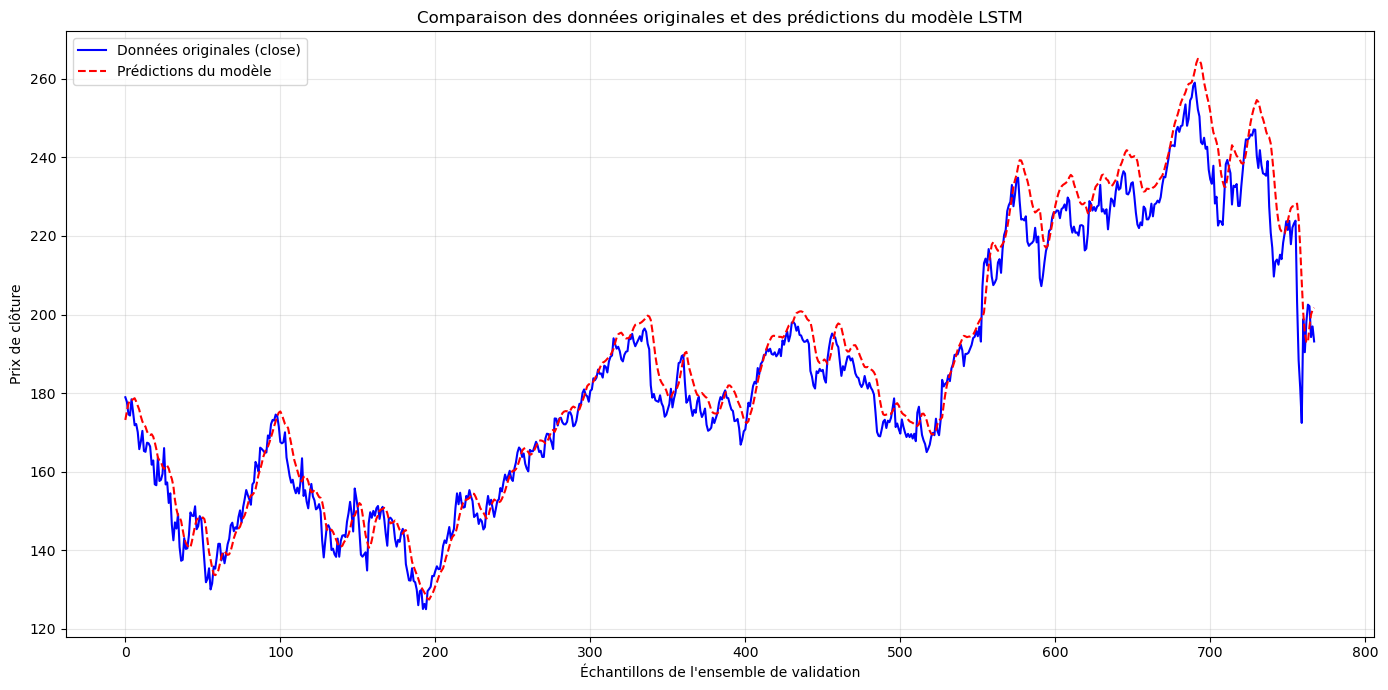

MAE: 5.0181
RMSE: 6.7405


In [31]:
# Préparer les données pour la visualisation
model.eval()
with torch.no_grad():
    # Faire des prédictions sur l'ensemble de validation
    predicted_val, _, _ = model(valX)
    
    # Convertir en numpy et dénormaliser
    predicted_val_np = predicted_val.numpy().flatten()
    y_val_np = valY.numpy().flatten()
    
    # Dénormalisation
    predicted_val_denorm = scaler_y.inverse_transform(predicted_val_np.reshape(-1, 1)).flatten()
    y_val_denorm = scaler_y.inverse_transform(y_val_np.reshape(-1, 1)).flatten()
    
    # Calculer les indices correspondants dans les données originales
    # train_size + seq_length est le point de départ de l'ensemble de validation
    val_indices = np.arange(train_size + seq_length, train_size + seq_length + len(predicted_val_denorm))
    
    # Récupérer les valeurs "close" originales pour ces indices
    original_close = data['close'].values
    
    # Créer un graphique
    plt.figure(figsize=(14, 7))
    
    # Tracer les données originales
    plt.plot(original_close[val_indices], label='Données originales (close)', color='blue')
    
    # Tracer les prédictions
    plt.plot(predicted_val_denorm, label='Prédictions du modèle', color='red', linestyle='--')
    
    # Personnaliser le graphique
    plt.title('Comparaison des données originales et des prédictions du modèle LSTM')
    plt.xlabel('Échantillons de l\'ensemble de validation')
    plt.ylabel('Prix de clôture')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Afficher le graphique
    plt.tight_layout()
    plt.show()
    
    # Afficher les métriques d'erreur
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

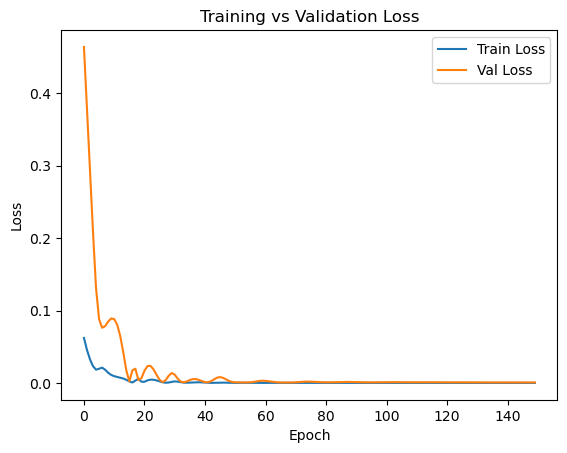

In [32]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


Features engineering

In [33]:
from tti.indicators._relative_strength_index import RelativeStrengthIndex
from tti.indicators._stochastic_oscillator import StochasticOscillator
from tti.indicators._standard_deviation import StandardDeviation
from tti.indicators._moving_average_convergence_divergence import MovingAverageConvergenceDivergence
from tti.indicators._ichimoku_cloud import IchimokuCloud
from tti.indicators._bollinger_bands import BollingerBands
from tti.indicators._average_true_range import AverageTrueRange

In [34]:
indicators = {"rsi": RelativeStrengthIndex, 
              "stochastic_oscillator": StochasticOscillator, 
              "standard_deviation": StandardDeviation, 
              "macd": MovingAverageConvergenceDivergence, 
              "ichimoku_cloud": IchimokuCloud, 
              "bollinger_bands": BollingerBands, 
              "atr": AverageTrueRange}

In [35]:
# Ajout d'indicateurs à la dataframe
for indc_name, indc in indicators.items():
    indc_instance = indc(data)
    indc_data = indc_instance.getTiData()
    data[indc_data.columns] = indc_data

c:\Users\peggy\Documents\Fabeon\deep_learning\brief_15bis\tti\utils\data_preprocessing.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
c:\Users\peggy\Documents\Fabeon\deep_learning\brief_15bis\tti\utils\data_preprocessing.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
c:\Users\peggy\Documents\Fabeon\deep_learning\brief_15bis\tti\utils\data_preprocessing.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
c:\Users\peggy\Documents\Fabeon\deep_learning\brief_15bis\tti\utils\data_preprocessing.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a futu

In [36]:
data


,open,high,low,close,volume,rsi,%k,%d,sd,macd,signal_line,tenkan_sen,kijun_sen,senkou_a,senkou_b,middle_band,upper_band,lower_band,atr
date,,,,,,,,,,,,,,,,,,,
2010-01-04,7.62,7.66,7.58,7.64,493729600,NaN,NaN,NaN,NaN,NaN,NaN,7.620,7.620,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,7.66,7.70,7.62,7.66,601904800,NaN,NaN,NaN,NaN,NaN,NaN,7.640,7.640,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,7.66,7.69,7.53,7.53,552160000,NaN,NaN,NaN,NaN,NaN,NaN,7.615,7.615,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,7.56,7.57,7.47,7.52,477131200,NaN,NaN,NaN,NaN,NaN,NaN,7.585,7.585,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,7.51,7.57,7.47,7.57,447876740,NaN,NaN,NaN,NaN,NaN,NaN,7.585,7.585,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-14,211.44,212.94,201.16,202.52,101352911,45.6690,59.0498,49.3175,15.3828,-8.9950,-8.3474,197.200,202.685,238.7325,239.740,208.6330,239.3986,177.8674,11.6030
2025-04-15,201.86,203.51,199.80,202.14,51343900,45.4755,58.3762,56.2430,15.4155,-8.2192,-8.3218,191.075,197.525,235.8550,239.740,208.1055,238.9364,177.2746,11.0392
2025-04-16,198.36,200.70,192.37,194.27,59732423,41.5569,44.4247,53.9502,15.6065,-8.1457,-8.2866,191.075,197.415,232.2325,238.775,207.0570,238.2700,175.8440,10.9485


In [37]:
data.stb.missing()


,missing,total,percent
signal_line,33,3848,0.857588
senkou_b,26,3848,0.675676
senkou_a,26,3848,0.675676
macd,25,3848,0.649688
lower_band,19,3848,0.493763
upper_band,19,3848,0.493763
middle_band,19,3848,0.493763
sd,19,3848,0.493763
%d,15,3848,0.389813
rsi,14,3848,0.363825


In [38]:
# Suppression des NaN
data.dropna(how='any', inplace=True)

In [39]:
data_fe = data.copy()

In [40]:
data_fe

,open,high,low,close,volume,rsi,%k,%d,sd,macd,signal_line,tenkan_sen,kijun_sen,senkou_a,senkou_b,middle_band,upper_band,lower_band,atr
date,,,,,,,,,,,,,,,,,,,
2010-02-22,7.23,7.23,7.11,7.16,390825032,46.9367,70.8333,80.0654,0.1561,-0.0523,-0.0937,7.115,7.245,7.4950,7.495,7.1085,7.4206,6.7964,0.1722
2010-02-23,7.14,7.19,6.99,7.04,575313660,42.8571,45.8333,65.2778,0.1532,-0.0576,-0.0865,7.115,7.245,7.4950,7.495,7.0980,7.4044,6.7916,0.1742
2010-02-24,7.08,7.19,7.07,7.17,460566400,48.1555,72.9167,63.1944,0.1431,-0.0506,-0.0793,7.115,7.245,7.4950,7.495,7.0890,7.3752,6.8028,0.1725
2010-02-25,7.05,7.24,7.03,7.21,665397144,49.6875,81.2500,66.6667,0.1250,-0.0414,-0.0717,7.140,7.245,7.4925,7.495,7.0785,7.3285,6.8285,0.1751
2010-02-26,7.23,7.33,7.21,7.31,507460856,53.4304,95.0000,83.0556,0.1346,-0.0258,-0.0625,7.160,7.210,7.4950,7.495,7.0880,7.3573,6.8187,0.1712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-14,211.44,212.94,201.16,202.52,101352911,45.6690,59.0498,49.3175,15.3828,-8.9950,-8.3474,197.200,202.685,238.7325,239.740,208.6330,239.3986,177.8674,11.6030
2025-04-15,201.86,203.51,199.80,202.14,51343900,45.4755,58.3762,56.2430,15.4155,-8.2192,-8.3218,191.075,197.525,235.8550,239.740,208.1055,238.9364,177.2746,11.0392
2025-04-16,198.36,200.70,192.37,194.27,59732423,41.5569,44.4247,53.9502,15.6065,-8.1457,-8.2866,191.075,197.415,232.2325,238.775,207.0570,238.2700,175.8440,10.9485


In [41]:
# Entraînement du modèle avec les features supplémentaires

In [42]:
np.random.seed(0)        
torch.manual_seed(0)     

In [43]:
# Fonction pour la création des séquences
def create_sequences(data_fe, seq_length):
    xs_fe = []
    ys_fe = []
    for i in range(len(data_fe)-seq_length):
        x_fe = data_fe[i:(i+seq_length)]
        y_fe = data_fe[i + seq_length, 3] 
        xs_fe.append(x_fe)
        ys_fe.append(y_fe)
    return np.array(xs_fe), np.array(ys_fe)

In [44]:
seq_length = 10                                                   
X_raw_fe, y_raw_fe = create_sequences(data_fe.values, seq_length)

In [45]:
# Normalisation des données
scaler_X_fe = MinMaxScaler()


In [46]:

n_samples, seq_len, n_features = X_raw_fe.shape
X_2d_fe = X_raw_fe.reshape(-1, n_features) 
X_scaled_2d_fe = scaler_X_fe.fit_transform(X_2d_fe) 
X_scaled_fe = X_scaled_2d_fe.reshape(n_samples, seq_len, n_features)
scaler_y_fe = MinMaxScaler()
y_scaled_fe = scaler_y_fe.fit_transform(y_raw_fe.reshape(-1, 1)).flatten()

In [47]:
# Split train/test (80% / 20%)
train_size_fe = int(len(X_scaled_fe) * 0.8)
X_train_fe, y_train_fe = X_scaled_fe[:train_size_fe], y_scaled_fe[:train_size_fe]
X_val_fe, y_val_fe = X_scaled_fe[train_size_fe:], y_scaled_fe[train_size_fe:]

In [48]:
# Conversion en tenseurs
trainX_fe = torch.tensor(X_train_fe, dtype=torch.float32)   #(batch_size, sequence_length, input_size)
trainY_fe = torch.tensor(y_train_fe[:, None], dtype=torch.float32)      # target en 2D pour la régression
valX_fe = torch.tensor(X_val_fe, dtype=torch.float32)
valY_fe = torch.tensor(y_val_fe[:, None], dtype=torch.float32)

In [60]:
# Modèle : instance de la classe avec dimensions d'entrée et de sortie spécifiées, des unités cachées et un nombre de couches LSTM.LSTMModel
model_fe = LSTMModel(input_dim=19, hidden_dim=256, layer_dim=1, output_dim=1)

# Fonction de perte : perte d'erreur quadratique moyenne (MSE) pour les tâches de régression.
criterion_fe = nn.MSELoss()

# Optimiseur Adam
optimizer_fe = torch.optim.Adam(model_fe.parameters(), lr=0.001)


In [61]:
# Entraînement du modèle avec features supplémentaires

In [62]:
num_epochs = 250
h0_fe, c0_fe = None, None

train_losses_fe = []
val_losses_fe = []

for epoch in range(num_epochs):
    model_fe.train()                                            # passe le modèle en mode d'entraînement.
    optimizer_fe.zero_grad()

    outputs_fe, h0_fe, c0_fe = model_fe(trainX_fe, h0_fe, c0_fe)

    loss_fe = criterion_fe(outputs_fe, trainY_fe)                        # comparaison des prédictions (outputs) au label réel (trainY).
    loss_fe.backward()                                          # calcul des gradients.
    optimizer_fe.step()                                         # mise à jour des poids du modèle.

    h0_fe = h0_fe.detach()
    c0_fe = c0_fe.detach()

    train_losses_fe.append(loss_fe.item())

    # Validation loss
    model_fe.eval()
    with torch.no_grad():
        val_pred_fe, _, _ = model_fe(valX_fe)
        val_loss_fe = criterion_fe(val_pred_fe, valY_fe)
        val_losses_fe.append(val_loss_fe.item())

    if (epoch+1) % 10 == 0:
        print(f"[FE]Epoch {epoch+1}/{num_epochs} - Train Loss : {loss_fe.item():.8f} - Val Loss: {val_loss_fe.item():.4f}")


[FE]Epoch 10/250 - Train Loss : 0.00245265 - Val Loss: 0.0135
[FE]Epoch 20/250 - Train Loss : 0.00061117 - Val Loss: 0.0017
[FE]Epoch 30/250 - Train Loss : 0.00063643 - Val Loss: 0.0009
[FE]Epoch 40/250 - Train Loss : 0.00013269 - Val Loss: 0.0032
[FE]Epoch 50/250 - Train Loss : 0.00010803 - Val Loss: 0.0011
[FE]Epoch 60/250 - Train Loss : 0.00010286 - Val Loss: 0.0008
[FE]Epoch 70/250 - Train Loss : 0.00007992 - Val Loss: 0.0013
[FE]Epoch 80/250 - Train Loss : 0.00007095 - Val Loss: 0.0007
[FE]Epoch 90/250 - Train Loss : 0.00006622 - Val Loss: 0.0007
[FE]Epoch 100/250 - Train Loss : 0.00006231 - Val Loss: 0.0007
[FE]Epoch 110/250 - Train Loss : 0.00005867 - Val Loss: 0.0006
[FE]Epoch 120/250 - Train Loss : 0.00005543 - Val Loss: 0.0005
[FE]Epoch 130/250 - Train Loss : 0.00005259 - Val Loss: 0.0005
[FE]Epoch 140/250 - Train Loss : 0.00005007 - Val Loss: 0.0005
[FE]Epoch 150/250 - Train Loss : 0.00004782 - Val Loss: 0.0004
[FE]Epoch 160/250 - Train Loss : 0.00004583 - Val Loss: 0.0004
[

In [63]:
model_fe.eval()
with torch.no_grad():                                                         
    predicted_val_fe, _, _ = model_fe(valX_fe)
    predicted_val_np_fe = predicted_val_fe.numpy().flatten()
    y_val_np_fe = valY_fe.numpy().flatten()

    # Dénormalisation
    predicted_val_denorm_fe = scaler_y_fe.inverse_transform(predicted_val_np_fe.reshape(-1, 1)).flatten()
    y_val_denorm_fe = scaler_y_fe.inverse_transform(y_val_np_fe.reshape(-1, 1)).flatten()


    mae_fe = mean_absolute_error(y_val_denorm_fe, predicted_val_denorm_fe)
    rmse_fe = math.sqrt(mean_squared_error(y_val_denorm_fe, predicted_val_denorm_fe))

    print(f"[FE]✅ MAE: {mae_fe:.2f} | RMSE: {rmse_fe:.2f}")

[FE]✅ MAE: 3.20 | RMSE: 4.48


In [64]:
# Visualation des résultats avec features supplémentaires

In [ ]:
# Préparer les données pour la visualisation
model_fe.eval()
with torch.no_grad():
    # Faire des prédictions sur l'ensemble de validation
    predicted_val_fe, _, _ = model_fe(valX_fe)
    
    # Convertir en numpy et dénormaliser
    predicted_val_np_fe = predicted_val_fe.numpy().flatten()
    y_val_np_fe = valY_fe.numpy().flatten()
    
    # Dénormalisation
    predicted_val_denorm_fe = scaler_y_fe.inverse_transform(predicted_val_np_fe.reshape(-1, 1)).flatten()
    y_val_denorm_fe = scaler_y_fe.inverse_transform(y_val_np_fe.reshape(-1, 1)).flatten()
    
    # Calculer les indices correspondants dans les données originales
    # train_size + seq_length est le point de départ de l'ensemble de validation
    val_indices_fe = np.arange(train_size_fe + seq_length, train_size_fe + seq_length + len(predicted_val_denorm_fe))
    
    # Récupérer les valeurs "close" originales pour ces indices
    original_close_fe = data_fe['close'].values
    
    # Créer un graphique
    plt.figure(figsize=(14, 7))
    
    # Tracer les données originales
    plt.plot(original_close_fe[val_indices_fe], label='Données originales (close)', color='blue')
    
    # Tracer les prédictions
    plt.plot(predicted_val_denorm_fe, label='Prédictions du modèle', color='red', linestyle='--')
    
    # Personnaliser le graphique
    plt.title('Comparaison des données originales et des prédictions du modèle LSTM avec features engineering')
    plt.xlabel('Échantillons de l\'ensemble de validation')
    plt.ylabel('Prix de clôture')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Afficher le graphique
    plt.tight_layout()
    plt.show()
    
    # Afficher les métriques d'erreur
    print(f"MAE: {mae_fe:.4f}")
    print(f"RMSE: {rmse_fe:.4f}")

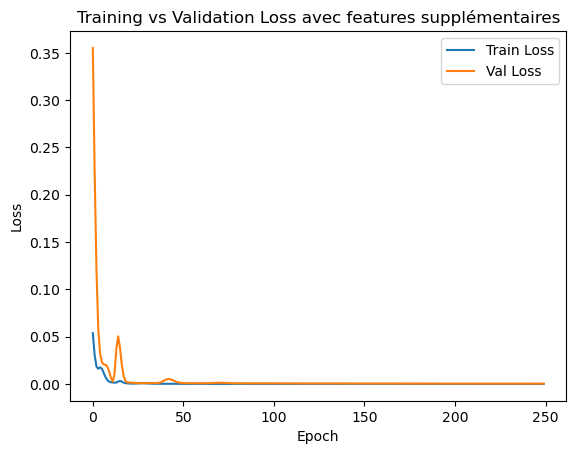

In [66]:
plt.plot(train_losses_fe, label='Train Loss')
plt.plot(val_losses_fe, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss avec features supplémentaires")
plt.show()

In [67]:
# Comparaison sans et avec features supplémentaires

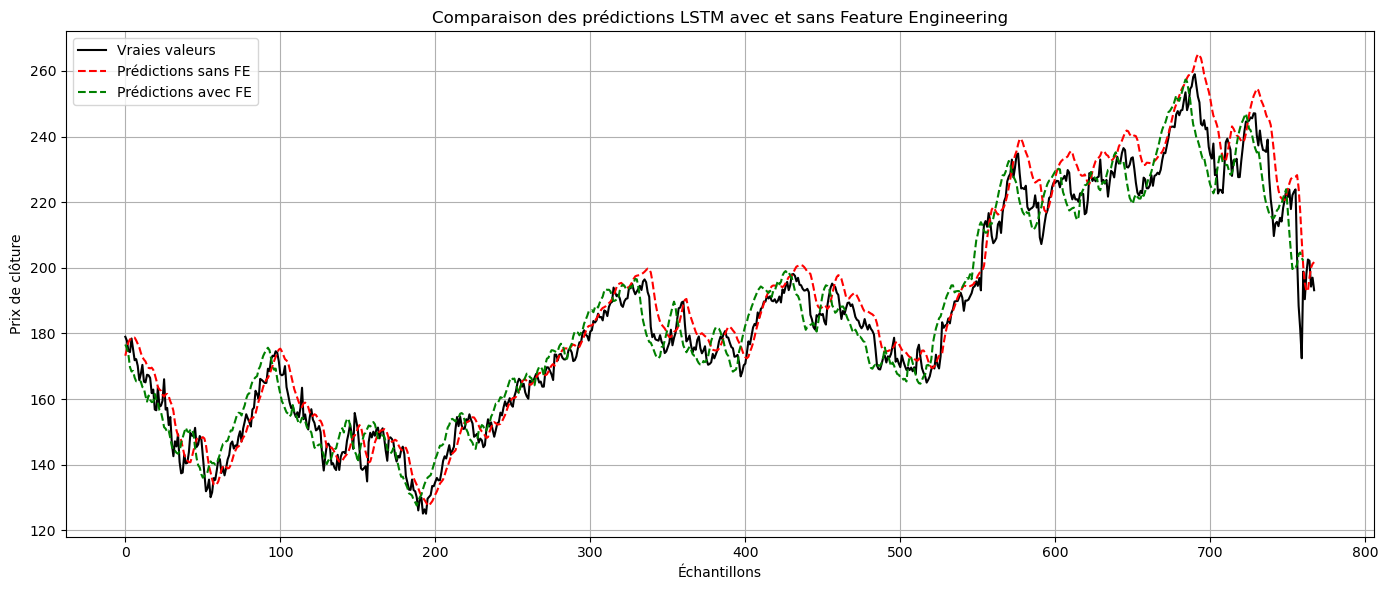

Sans FE - MAE: 5.02 | RMSE: 6.74
Avec FE - MAE: 3.20 | RMSE: 4.48


In [68]:
plt.figure(figsize=(14, 6))

plt.plot(y_val_denorm, label="Vraies valeurs", color="black")
plt.plot(predicted_val_denorm, label="Prédictions sans FE", linestyle="--", color="red")
plt.plot(predicted_val_denorm_fe, label="Prédictions avec FE", linestyle="--", color="green")

plt.title("Comparaison des prédictions LSTM avec et sans Feature Engineering")
plt.xlabel("Échantillons")
plt.ylabel("Prix de clôture")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Sans FE - MAE: {mae:.2f} | RMSE: {rmse:.2f}")
print(f"Avec FE - MAE: {mae_fe:.2f} | RMSE: {rmse_fe:.2f}")
